# New Section

In [86]:
# Biblioteke
import numpy as np
import pandas as pd
import cv2
import random as rn
import time
import os
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
from matplotlib import pyplot as plt

from keras.models import Model, save_model
from keras.layers import Flatten, Dense, LeakyReLU
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.optimizers import Adam 
from keras.utils import to_categorical
from keras import backend as K


%matplotlib inline

In [2]:
# Cuvanje checkpoint-a
!pip install pyyaml h5py
import h5py

In [3]:
# Pristup drive-u
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Consts
seed_value= 7
np.random.seed(seed_value)
rn.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

HEIGHT = 224
WIDTH = 224


In [19]:
# 0 - originalni potpis
# 1 - lazni potpis
# Ucitavanje privatnih podataka
reading_data = pd.read_csv("/content/gdrive/My Drive/dataset&csv/labeling_file.csv", sep=',')

print("Broj slika: " + str(len(reading_data)))

label_column = reading_data[reading_data.columns[1]]
print(label_column.value_counts())

print("------------------------------")
print("Nedostajuce vrednosti: ")
print(reading_data.isnull().sum()!=0) 

print("------------------------------")
print(reading_data.head())
print("------------------------------")
print(reading_data.tail())
print("------------------------------")


Broj slika: 1244
0    772
1    472
Name: flag_forge, dtype: int64
------------------------------
Nedostajuce vrednosti: 
image_name    False
flag_forge    False
dtype: bool
------------------------------
         image_name  flag_forge
0  sign_0000_01.jpg           0
1  sign_0000_02.jpg           0
2  sign_0000_03.jpg           0
3  sign_0000_04.jpg           0
4  sign_0000_05.jpg           0
------------------------------
              image_name  flag_forge
1239  sign_f_0088_04.png           1
1240  sign_f_0088_05.png           1
1241  sign_f_0088_06.png           1
1242  sign_f_0088_07.png           1
1243  sign_f_0088_08.png           1
------------------------------


In [31]:
read_images = []

for img_name in reading_data["image_name"]:

  tmp_img = cv2.imread("/content/gdrive/My Drive/dataset&csv/dataset/" + img_name)
  read_images.append(tmp_img)


In [32]:
read_images = np.array(read_images)
read_images.shape

(1244,)

In [33]:
# Promena dimenzija slika
nr_pictures = len(read_images)
dataset_resized = np.repeat(0, HEIGHT*WIDTH*nr_pictures*3)
dataset_resized = np.reshape(dataset_resized, (nr_pictures, HEIGHT, WIDTH, 3))

dataset_resized.shape

(1244, 224, 224, 3)

In [34]:
for i, image in enumerate(read_images):
  dataset_resized[i] = cv2.resize(image, (WIDTH,HEIGHT))

In [35]:
# Target kolona
y = np.array(reading_data["flag_forge"])
read_images = []

In [36]:
# Podela podataka
X_train, X_test, y_train, y_test = train_test_split(dataset_resized, y, test_size=0.15, random_state=42, stratify = y)

dataset_resized = []

In [37]:
# Preprocesiranje za VGG16
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)



In [38]:
# Broj klasa
C = 2

# Prikaz
y1_train = to_categorical(y_train, C)
y1_test = to_categorical(y_test, C)

In [39]:
# Model koji se nalazi u osnovi mreze
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

58892288/58889256 [==============================] - 1s 0us/step


In [41]:
for layer in base_model.layers:
  layer.trainable = False

# Ostatak modela
x_input = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x_input)
x = Dense(2048)(x)
x = LeakyReLU(alpha=0.15)(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.20)(x)
preds = Dense(C, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=preds)

In [42]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [45]:
model.compile(optimizer = Adam(learning_rate=0.00005) , loss="binary_crossentropy", metrics = ["acc",
                                                                                               tf.keras.metrics.AUC(),
                                                                                               tf.keras.metrics.TruePositives(),
                                                                                               tf.keras.metrics.TrueNegatives(),
                                                                                               tf.keras.metrics.FalsePositives(),
                                                                                               tf.keras.metrics.FalseNegatives()
                                                                                               ])

In [46]:
#Hiperparametri
epochs = 20
batch_size = 64

verbose = 1

t = time.time()

In [47]:
# Balansiranje tezina klasa zbog nejednakog prisustva 2 klase
w0 = (1/772) * (1244)/2.0
w1 = (1/472) * (1244)/2.0

class_weight = {
    0 : w0,
    1 : w1
}

In [49]:
history = model.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    validation_split = 0.15,
                    class_weight = class_weight
                    )

    
print('Training time: %s' % (time.time()-t))

Epoch 1/20
15/15 [==============================] - 491s 33s/step - loss: 0.6869 - acc: 0.5969 - auc_2: 0.6508 - true_positives: 536.0000 - true_negatives: 536.0000 - false_positives: 362.0000 - false_negatives: 362.0000 - val_loss: 0.4162 - val_acc: 0.7736 - val_auc_2: 0.8914 - val_true_positives: 123.0000 - val_true_negatives: 123.0000 - val_false_positives: 36.0000 - val_false_negatives: 36.0000
Epoch 2/20
15/15 [==============================] - 492s 33s/step - loss: 0.3991 - acc: 0.8185 - auc_2: 0.8990 - true_positives: 735.0000 - true_negatives: 735.0000 - false_positives: 163.0000 - false_negatives: 163.0000 - val_loss: 0.3079 - val_acc: 0.8491 - val_auc_2: 0.9481 - val_true_positives: 135.0000 - val_true_negatives: 135.0000 - val_false_positives: 24.0000 - val_false_negatives: 24.0000
Epoch 3/20
15/15 [==============================] - 489s 33s/step - loss: 0.2862 - acc: 0.8842 - auc_2: 0.9544 - true_positives: 794.0000 - true_negatives: 794.0000 - false_positives: 104.0000 - f

In [50]:
# Metrike 
val_auc_hist = history.history["val_acc"]
val_loss_hist = history.history["val_loss"]
train_auc_hist = history.history["acc"]
train_loss_hist = history.history["loss"]

epochs = history.epoch

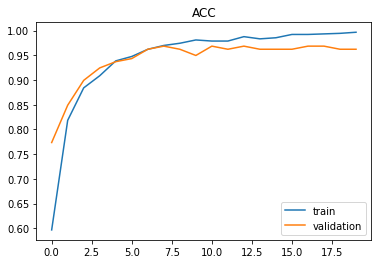

In [51]:
# Grafik tacnosti
plt.title("ACC")
plt.plot(epochs, train_auc_hist, label="train")
plt.plot(epochs, val_auc_hist, label = "validation")
plt.legend()

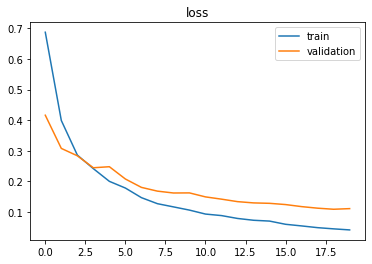

In [52]:
# Grafik funkcije gubitka
plt.title("loss")
plt.plot(epochs, train_loss_hist, label="train")
plt.plot(epochs, val_loss_hist, label = "validation")
plt.legend()

In [ ]:
#Provera modela bez fine tuning-a nad podacima za trening

# TRAIN SET

# loss and acc calculated on whole train set
#train_loss, train_acc, train_mse = model.evaluate(X_train, y1_train)
# Predicted probabilities on train set
#y_probs_train = model.predict(X_train)[:,1]
# Predicted categories on train set, using threshold 0.5
#y_pred_train = np.array([int(prob > 0.5) for prob in y_probs_train])

#print("TRAIN SET")
#print("true values: ", y_train)
#print("predicted values: ", y_pred_train)

In [ ]:
#Provera modela bez fine tuning-a nad podacima za test

# TEST SET

# loss and acc calculated on whole test set
#test_loss, test_acc, test_mse = model.evaluate(X_test, y1_test)
# Predicted probabilities on test set
#y_probs_test = model.predict(X_test)[:,1]
# Predicted categories on test set, using threshold 0.5
#y_pred_test = np.array([int(prob > 0.5) for prob in y_probs_test])

#print("TEST SET")
#print("true values: ", y_test)
#print("predicted values: ", y_pred_test)
#print(np.abs(y_pred_test - y_test).size)
#np.count_nonzero(np.abs(y_pred_test - y_test) == 0)

In [53]:
# Checkpoints
checkpoint_path = '/content/gdrive/My Drive/'+'checkpoint-'+'-epoch-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)
direktorijum = checkpoint_dir + ""
print(direktorijum)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1)

/content/gdrive/My Drive


In [54]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
# Fine tuning
for layer in base_model.layers:
  layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
             loss="binary_crossentropy",
              metrics = ["acc",
                         tf.keras.metrics.AUC(),
                         tf.keras.metrics.TruePositives(),
                         tf.keras.metrics.TrueNegatives(),
                         tf.keras.metrics.FalsePositives(),
                         tf.keras.metrics.FalseNegatives()
                         ])


model.summary()
epochs = 5

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [56]:
history = model.fit(X_train,
                    y1_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    validation_split = 0.15, 
                    class_weight = class_weight,
                    callbacks = cp_callback)

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.1626 - acc: 0.9265 - auc_3: 0.9843 - true_positives_1: 832.0000 - true_negatives_1: 832.0000 - false_positives_1: 66.0000 - false_negatives_1: 66.0000  
Epoch 00001: saving model to /content/gdrive/My Drive/checkpoint--epoch-01-0.95.hdf5
15/15 [==============================] - 1581s 105s/step - loss: 0.1626 - acc: 0.9265 - auc_3: 0.9843 - true_positives_1: 832.0000 - true_negatives_1: 832.0000 - false_positives_1: 66.0000 - false_negatives_1: 66.0000 - val_loss: 0.1062 - val_acc: 0.9497 - val_auc_3: 0.9943 - val_true_positives_1: 151.0000 - val_true_negatives_1: 151.0000 - val_false_positives_1: 8.0000 - val_false_negatives_1: 8.0000
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.0399 - acc: 0.9911 - auc_3: 0.9995 - true_positives_1: 890.0000 - true_negatives_1: 890.0000 - false_positives_1: 8.0000 - false_negatives_1: 8.0000  
Epoch 00002: saving model to /content/gdrive/My Drive/checkpoint--ep

In [57]:
val_auc_hist = history.history["val_acc"]
val_loss_hist = history.history["val_loss"]
train_auc_hist = history.history["acc"]
train_loss_hist = history.history["loss"]

epochs = history.epoch

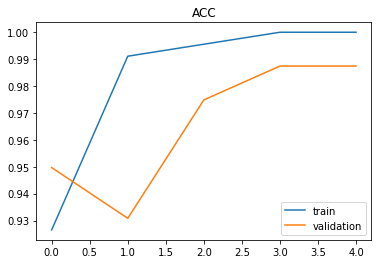

In [58]:
#Grafik tacnosti posle fine tuning-a
plt.title("ACC")
plt.plot(epochs, train_auc_hist, label="train")
plt.plot(epochs, val_auc_hist, label = "validation")
plt.legend()

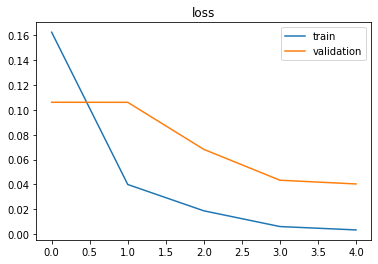

In [97]:
# Grafik funkcije gubitka posle fine tuning-a 
plt.title("loss")
plt.plot(epochs, train_loss_hist, label="train")
plt.plot(epochs, val_loss_hist, label = "validation")
plt.legend()

In [61]:
# TRAIN SET

# Metrike
train_loss, train_acc, train_auc, train_tp, train_tn, train_fp, train_fn = model.evaluate(X_train, y1_train)

y_probs_train = model.predict(X_train)[:,1]

# < 0.4 ===> 0
# >=0.4 ===> 1
y_pred_train = np.array([int(prob > 0.4) for prob in y_probs_train])

34/34 [==============================] - 512s 15s/step - loss: 0.0079 - acc: 0.9981 - auc_3: 1.0000 - true_positives_1: 1055.0000 - true_negatives_1: 1055.0000 - false_positives_1: 2.0000 - false_negatives_1: 2.0000


In [62]:
# TEST SET

# Metrike
test_loss, test_acc, test_auc, test_tp, test_tn, test_fp, test_fn = model.evaluate(X_test, y1_test)

y_probs_test = model.predict(X_test)[:,1]

# < 0.4 ===> 0
# >=0.4 ===> 1
y_pred_test = np.array([int(prob > 0.4) for prob in y_probs_test])


print("TEST SET")
print("true values: ", y_test)
print("predicted values: ", y_pred_test)
print(np.abs(y_pred_test - y_test).size)
np.count_nonzero(np.abs(y_pred_test - y_test) == 0)

6/6 [==============================] - 78s 13s/step - loss: 0.0337 - acc: 0.9840 - auc_3: 0.9997 - true_positives_1: 184.0000 - true_negatives_1: 184.0000 - false_positives_1: 3.0000 - false_negatives_1: 3.0000
TEST SET
true values:  [0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0
 1 0]
predicted values:  [0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1 0 0
 0 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0

184

In [106]:
#Confution Matrix and Classification Report
#Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)

print('*************Confusion Matrix*************')
print(pd.DataFrame(confusion_matrix(y1_test[:,1], y_pred_test), index=["0","1"], columns=["0","1"]))

print("--------------------------------------------------------")

print('*************Classification Report*************')
target_names = ['Original', 'Fake']
print(classification_report(y1_test[:,1], y_pred_test, target_names=target_names))

*************Confusion Matrix*************
     0   1
0  113   3
1    0  71
--------------------------------------------------------
*************Classification Report*************
              precision    recall  f1-score   support

    Original       1.00      0.97      0.99       116
        Fake       0.96      1.00      0.98        71

    accuracy                           0.98       187
   macro avg       0.98      0.99      0.98       187
weighted avg       0.98      0.98      0.98       187



In [98]:
'''Testiranje pojedinacne slike
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image)#.astype('float32')/255
   np_image = transform.resize(np_image, (244, 244, 3))
   np_image = preprocess_input(np_image)
   np_image = np.expand_dims(np_image, axis=0)
   return np_image
#X_test[0].show()
#print(X_test[0].shape)
image = load('/content/gdrive/My Drive/8.jpeg')
model.predict(image)[:,1]
'''

"Testiranje pojedinacne slike\nfrom PIL import Image\nimport numpy as np\nfrom skimage import transform\ndef load(filename):\n   np_image = Image.open(filename)\n   np_image = np.array(np_image)#.astype('float32')/255\n   np_image = transform.resize(np_image, (244, 244, 3))\n   np_image = preprocess_input(np_image)\n   np_image = np.expand_dims(np_image, axis=0)\n   return np_image\n#X_test[0].show()\n#print(X_test[0].shape)\nimage = load('/content/gdrive/My Drive/8.jpeg')\nmodel.predict(image)[:,1]\n"

In [87]:
# Cuvanje modela
model.save('nasModel.h5')